# Topic extraction

This code provides the explanation on how to extract the topics out of the data.

## Set up

## Install libraries

In [22]:
!pip install contractions

## Import libraries

In [23]:
import numpy as np
import pandas as pd
import json
import contractions
from google.colab import drive

## Connect to colab

In [24]:

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

### Load all the interventions

In [25]:
final = pd.read_csv("/content/drive/MyDrive/daiwoz/interventions.csv",index_col=0)

We perform a little preprocess as there are initial words that start with "<>" and our code would not detect them

In [26]:
### Some preprocess, in some case

# Copy the original column
import re
def remove_starting_word(text):
    if isinstance(text, str):
        pattern = r'^<\w+>\s*'  # Regex pattern to match <word> at the beginning of the text
        return re.sub(pattern, '', text)
    else:
        return text


final['interventions'] = final['value']



# Perform the extraction
final['value'] = final['value'].str.extract('\((.*?)\)', expand=False)
final['value'].fillna(final['interventions'], inplace=True)
final['value'] = final['value'].apply(lambda x: remove_starting_word(x))
final.drop("interventions",axis=1)

,start_time,stop_time,speaker,value,id
0,36.588,39.668,Ellie,hi i'm ellie thanks for coming in today,300
1,39.888,43.378,Ellie,i was created to talk to people in a safe and ...,300
2,43.728,48.498,Ellie,think of me as a friend i don't judge i can't ...,300
3,49.188,52.388,Ellie,i'm here to learn about people and would love ...,300
4,52.658,58.958,Ellie,i'll ask a few questions to get us started and...,300
...,...,...,...,...,...
290,886.374,888.814,Ellie,okay i think i have asked everything i need to,492
291,889.513,890.953,Ellie,thanks for sharing your thoughts with me,492
292,891.758,892.368,Ellie,goodbye,492
293,891.800,892.940,Participant,bye and thank you,492


### Extract Ellie's questions

In [27]:
# Filter the data for speaker 'Ellie'
ellie_data = final[final['speaker'] == 'Ellie']

# List of question starters
question_starters = ['who', 'how', 'what', 'which', 'where', 'when', 'why', 'do', 'does', 'did', 'have', 'has', 'had', 'can', 'could', 'will', 'would', 'should', 'are', 'is', 'was', 'were', "tell me"]

# Function to check if a sentence starts with a question starter
def starts_with_question_starter(sentence):
    if isinstance(sentence, str):
        for qs in question_starters:
            if sentence.lower().startswith(qs):
                return True
    return False



# Filter the 'value' column for sentences that start with a question starter
ellie_questions = ellie_data[ellie_data['value'].apply(starts_with_question_starter)]


# Display the questions asked by 'Ellie'
list(set(question.strip() for question in ellie_questions['value'].unique()))

['how did you decide to do that',
 'what made you decide to go and see someone',
 'what are you',
 'what do you do when you are annoyed',
 'tell me about your kids',
 'are you happy you did that',
 'what advice would you give yourself ten or twenty years ago',
 'is it uncomfortable for you to talk about this',
 'are you still working in that',
 'what were your symptoms',
 'why',
 'can you give me an example of that',
 'how close are you to your family <asks do you travel a lot simultaneously>',
 'what did you do after the military',
 'how does it compare to l_a',
 'how are you doing today',
 'how close are you to them',
 'why did you stop',
 'do you consider yourself more shy or outgoing',
 'what do you enjoy about traveling',
 'when was the last time that happened',
 "what are some things you don't really like about l_a",
 "do you think that maybe you're being a little hard on yourself",
 'do you feel like therapy is useful',
 'tell me about an event or something that you wish you cou

### Load Question categories

Fun fact, these categories were provided by chatGPT 🧠

In [28]:
# Load the data from a JSON file
with open('/content/drive/MyDrive/daiwoz/more_questions.json') as f:
    data = json.load(f)

# Create a list to hold the data
rows_list = []

# Loop through each category
for category, questions in data.items():
    for question in questions:
        # Create a new row for each question
        row_dict = {}
        row_dict["Category"] = category
        row_dict["Question"] = question
        rows_list.append(row_dict)

# Create DataFrame
df = pd.DataFrame(rows_list)

# Expand contractions in questions
df['Question'] = df['Question'].apply(lambda x: contractions.fix(x))
df = df.drop_duplicates()

In [29]:
df.Category.value_counts()

Followup Questions             38
Mental Health                  20
Personality and Behaviour      17
Geographical and Relocation    13
Career and Education           10
Family Life                     9
Interpersonal Relationships     6
Regrets and Past Decisions      6
Travel                          2
Name: Category, dtype: int64

In order for the process to work, we also add the end of interview sentences used by Ellie, this way we will avoid addind these to our final dataset

In [30]:
df = pd.concat([df,pd.DataFrame([("End","okay i think i have asked everything i need to"),("End","okay i think i've asked everything i need to")],columns=["Category","Question"])])

Followup Questions are those that are not opening a new topic, so it is not necessary to cut the intervention when these appear.

In [31]:
len(df.loc[df.Category != "Followup Questions"].Question.unique())

85

## Data preprocess

### Compute embeddings for the questions

We will compute the embeddings using USE from google, this way we can detect questions that talk about the same

In [32]:
import tensorflow_hub as hub
import numpy as np

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [33]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

def embed(input):
    return model(input)

# Assuming 'df' is your DataFrame and 'questions' is the column containing questions
questions = df.loc[df.Category != "Followup Questions"].Question.unique()

# Compute embeddings for all questions
question_embeddings_plot = embed(questions)
question_embeddings = embed(questions)
# Compute pairwise cosine similarity
similarity_matrix = cosine_similarity(question_embeddings)

# Initialize a list to store the indices of questions to be dropped
indices_to_drop = []

# For each question, find the indices of questions with cosine similarity > 0.80
for i in range(similarity_matrix.shape[0]):
    # Exclude the similarity of the question with itself by setting it to 0
    similarity_matrix[i, i] = 0

    similar_question_indices = np.where(similarity_matrix[i] > 0.80)[0]

    # If more than one question have cosine similarity > 0.80, mark this question to be dropped
    if len(similar_question_indices) > 1:
        indices_to_drop.append(i)

print("Dropping questions: ",indices_to_drop)
# Drop these questions from the DataFrame
df = df.drop(df.index[indices_to_drop])

# Reset index after dropping rows
df = df.reset_index(drop=True)


question_embeddings = embed(df.loc[df.Category != "Followup Questions"].Question.unique())

Dropping questions:  [7, 8, 12, 40, 41, 43, 75]


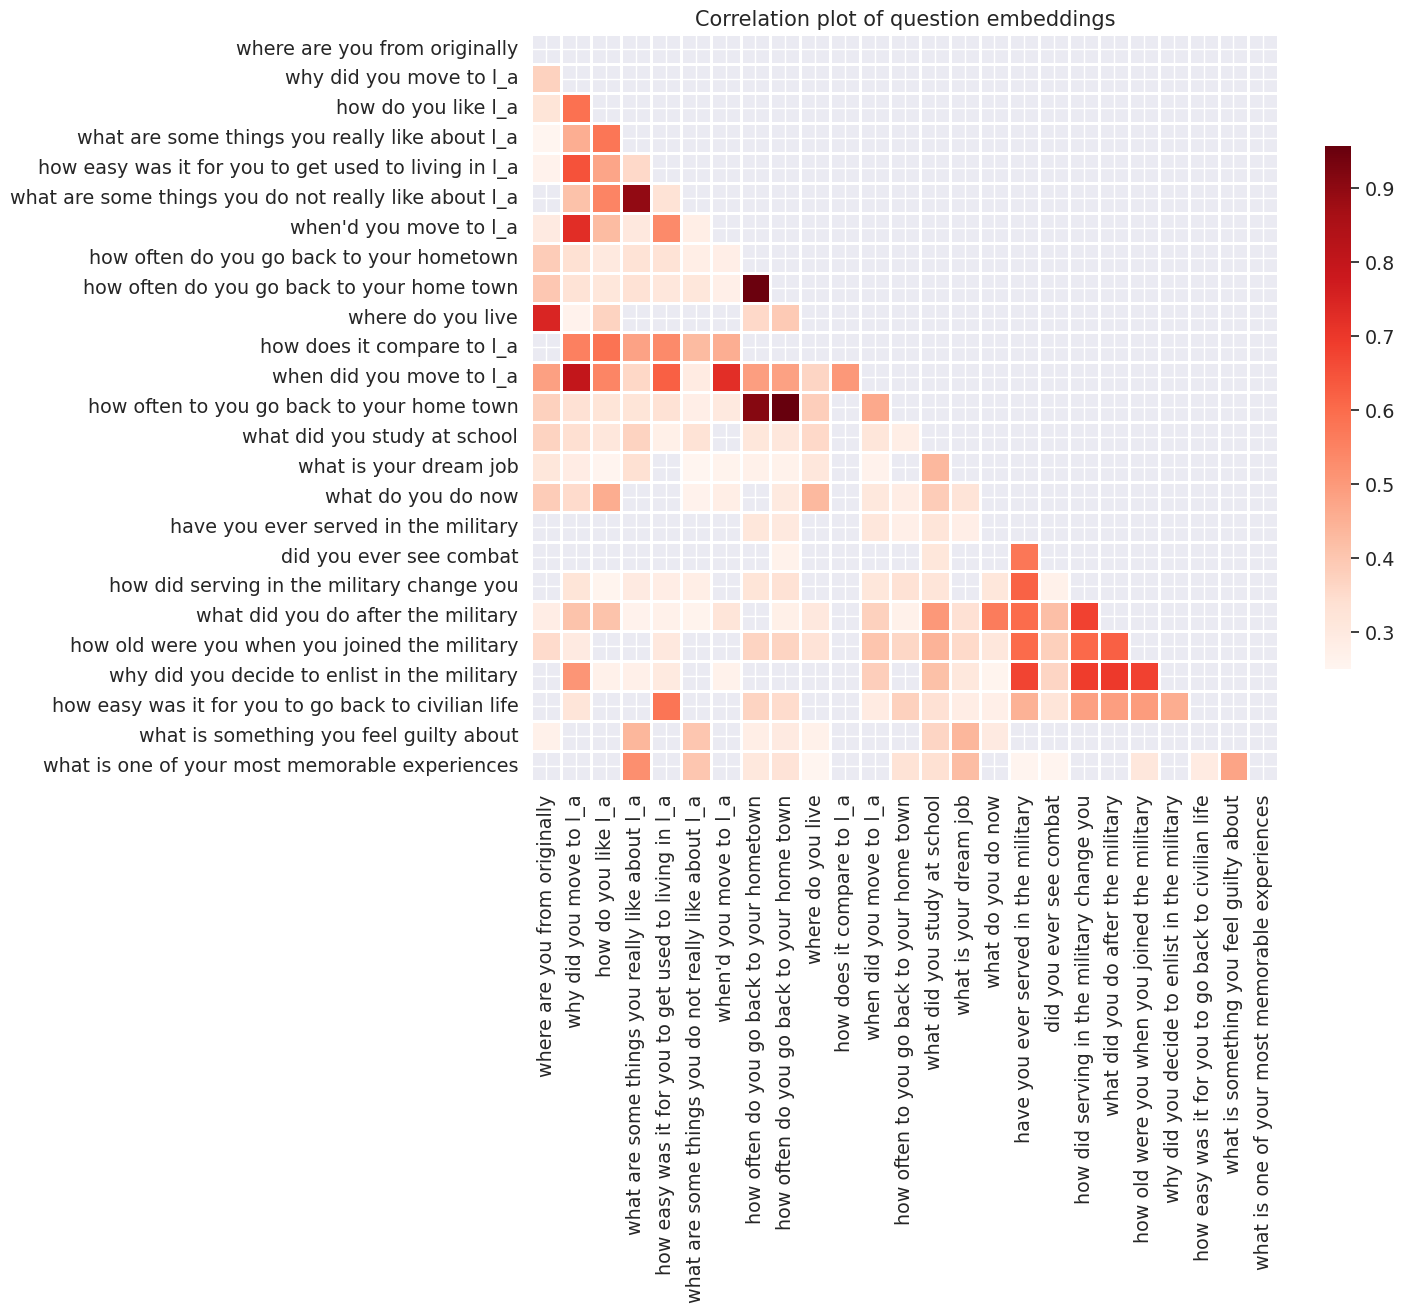

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a mask for correlations above 0.6
mask = np.where(similarity_matrix > 0.25, True, False)

# Apply the mask to the similarity matrix
masked_similarity_matrix = np.where(mask, similarity_matrix, np.nan)

# Since many elements are now NaN, we should remove the rows and columns with only NaNs
nan_cols = np.all(np.isnan(masked_similarity_matrix), axis=0)  # cols with all NaNs
nan_rows = np.all(np.isnan(masked_similarity_matrix), axis=1)  # rows with all NaNs
masked_similarity_matrix = masked_similarity_matrix[~nan_rows][:, ~nan_cols]
questions_filtered = questions[~nan_rows]

# Check if there are more than 25 questions
if len(questions_filtered) > 25:
    # If there are more than 25 questions, select the first 25
    questions_filtered = questions_filtered[:25]
    masked_similarity_matrix = masked_similarity_matrix[:25, :25]

# Create a mask for the upper triangle of the matrix
mask_upper_triangle = np.ones(masked_similarity_matrix.shape).astype(bool)
mask_upper_triangle[np.tril_indices(masked_similarity_matrix.shape[0])] = False

# Create the heatmap
plt.figure(figsize=(15, 15))  # Adjust figure size for better readability
sns.set(font_scale=1.25)  # Adjust font size so that labels fit
ax = sns.heatmap(masked_similarity_matrix,
                 cmap='Reds', linewidths=1, square=True,cbar_kws={"shrink": .5}, mask=mask_upper_triangle)

# Place the question text on the axes
ax.set_xticklabels(questions_filtered, rotation=90)
ax.set_yticklabels(questions_filtered, rotation=0)

plt.title('Correlation plot of question embeddings')
plt.tight_layout()  # Make sure layout is tight so labels are not cut off
plt.show()





### Functions for cleansing the data

In [35]:
import pandas as pd
import re
from itertools import chain
from collections import Counter

final = pd.read_csv("/content/drive/MyDrive/daiwoz/interventions.csv",index_col=0)
# Copy the original column
final['interventions'] = final['value']

# Perform the extraction
final['value'] = final['value'].str.extract('\((.*?)\)', expand=False)
final['value'].fillna(final['interventions'], inplace=True)
final = final.reset_index(drop=True)
final = final.drop("interventions",axis=1)
final['value'] = final['value'].astype(str)
final['value'].replace(['missing_value', 'NA',"nan","scrubbed_entry"], np.nan, inplace=True)
final = final.dropna(axis=0)

def find_special_tokens(text):
    pattern = r'\<(.*?)>'
    special_tokens = re.findall(pattern, text)
    return special_tokens

# Assume df is your DataFrame and 'text' is the column with the text data
special_tokens = list(chain.from_iterable(final['value'].apply(find_special_tokens)))

# Create a Counter from the list of special tokens
token_counts = Counter(special_tokens)

for token, count in sorted(token_counts.items(), key=lambda item: item[1], reverse=True):
    print(f'{token}: {count}')

laughter: 1590
sigh: 676
clears throat: 143
deep breath: 120
sniffle: 91
synch: 82
s: 58
tisk: 56
sniff: 54
sync: 43
f: 36
ha: 32
wa: 30
th: 28
snort: 27
m: 24
t: 21
l: 21
w: 20
y: 17
li: 16
n: 16
ss: 15
cough: 14
d: 14
so: 14
st: 14
i: 14
wh: 13
o: 12
sharp inhale: 11
bout: 10
yawn: 10
makes sound with mouth: 10
sh: 10
rea: 10
a: 10
r: 9
lo: 8
go: 8
do: 8
coughs: 8
wou: 7
we: 7
ex: 7
j: 7
ma: 7
ta: 6
tr: 6
re: 6
di: 6
yawning: 6
g: 6
h: 6
talking to experimenter: 6
the: 5
thi: 5
c: 5
ne: 5
p: 5
be: 5
ca: 5
peo: 5
kn: 5
po: 5
fam: 5
mumbling: 5
se: 4
ba: 4
prob: 4
te: 4
fi: 4
ch: 4
someti: 4
fe: 4
per: 4
b: 4
ju: 4
si: 4
con: 4
no: 4
fo: 4
makes sounds with mouth: 4
he: 4
whe: 4
mo: 4
ki: 4
wi: 4
u: 4
e: 3
peop: 3
stu: 3
pa: 3
ho: 3
abo: 3
su: 3
see: 3
exp: 3
anyth: 3
wha: 3
an: 3
ye: 3
to: 3
ok: 3
sch: 3
wor: 3
thin: 3
ti: 3
mi: 3
on: 3
psh: 3
diff: 3
en: 3
real: 3
un: 3
mea: 3
fu: 3
rel: 3
me: 3
ana: 3
la: 3
co: 3
as: 2
pos: 2
ver: 2
makes clicking sounds with mouth: 2
el: 2
inv: 2
m

In [36]:
def find_underscore_words(text):
    pattern = r'\b\w+_\w+\b'
    underscore_words = re.findall(pattern, text)
    return underscore_words

# Assume df is your DataFrame and 'text' is the column with the text data
special_tokens = list(chain.from_iterable(final['value'].apply(find_underscore_words)))

# Create a Counter from the list of special tokens
token_counts = Counter(special_tokens)

for token, count in sorted(token_counts.items(), key=lambda item: item[1], reverse=True):
    print(f'{token}: {count}')

l_a: 770
p_t_s_d: 192
t_v: 63
u_c_l_a: 13
u_s: 12
u_s_c: 10
l_a_x: 5
g_e_d: 5
d_c: 5
b_s: 4
a_m: 4
m_b_a: 3
a_d_h_d: 3
a_a: 3
a_p: 3
p_h_d: 3
d_u_i: 3
u_c: 3
e_r: 3
s_m_c: 2
i_t: 2
j_c: 2
b_f_a: 2
c_e_o: 2
g_p_s: 2
i_q: 2
n_r_a: 1
p_t: 1
v_a: 1
n_f_l: 1
b_sers: 1
p_h_ds: 1
c_s: 1
h_r: 1
n_s_f: 1
v_w: 1
d_v_d: 1
t_m_z: 1
h_b_o: 1
m_o: 1
g_e: 1
b_p_a: 1
m_m_p_h: 1
m_t_a: 1
d_b_t: 1
o_b: 1
c_section: 1
l_v_a: 1
f_b_i: 1
p_m: 1
o_c_d: 1
h_g_t_v: 1
n_b_a: 1
s_x: 1
s_c: 1
o_b_g: 1
c_d_c: 1
c_o_p_d: 1
m_c_i: 1
d_v_ds: 1
d_c_f_s: 1
s_s_i: 1
a_c: 1
s_t_ds: 1
r_s_d: 1
e_t_fs: 1
r_t_m: 1
l_v_n: 1
m_d: 1
p_c_h: 1
c_d: 1


In [37]:
all_questions = df.loc[df.Category != "Followup Questions"].Question.unique()

We end up not cleaning for the final dataset, we find that the model might be learning from these inputs as they provide context. However it is possible that the text model need fine tuning in order to recognize them correctly

In [38]:
def remove_repetitions(text):
    words = [word.lower().strip('!?') for word in text.split()]
    result = [words[0]]

    for i in range(1, len(words)):
        if words[i] != result[-1]:
            result.append(words[i])

    return ' '.join(result)

def delete_bracketed_words(text):
    pattern = r'<(.*?)>'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text.strip()

def delete_bracketed_words2(text):
    pattern = r'\[(.*?)\]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text.strip()

def replace_underscore_words(text):
    pattern = r'\b\w+_\w+\b'
    underscore_words = re.findall(pattern, text)

    for word in underscore_words:
        text = text.replace(word, word.replace('_', '').upper())

    return text

"""
final['value'] = final['value'].apply(lambda x: remove_repetitions(x))
final['value'] = final['value'].str.replace('<laughter>', '(laughter)')
final['value'] = final['value'].str.replace('/[laughter/]', '(laughter)')
final['value'] = final['value'].str.replace('<sigh>', '(sigh)')
final['value'] = final['value'].str.replace('<clears throat>', '(clears throat)')
final['value'] = final['value'].str.replace('<deep breath>', '(deep breath)')
final['value'] = final['value'].str.replace('<sniffle>', '(sniff)')
final['value'] = final['value'].str.replace('<sniff>', '(sniff)')
final['value'] = final['value'].apply(delete_bracketed_words)
final['value'] = final['value'].apply(delete_bracketed_words2)
final['value'] = final['value'].apply(replace_underscore_words)
"""
def clean_text(text):
    pattern = r'[\[\]<>]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text.strip()

final['value'] = final['value'].apply(lambda x: clean_text(x))

### Compute all question interventions on the dataset

In [39]:


def extract_segments(dataframe, questions):
    sub_datasets = {question: [] for question in questions}
    for conversation_id in dataframe['id'].unique():
        conversation = dataframe[dataframe['id'] == conversation_id]
        current_question = None
        for _, row in conversation.iterrows():
            if row['speaker'] == 'Ellie':
                # Compute embedding for row value
                row_embedding = embed([row['value'].strip()])
                # Compute similarities with all question embeddings
                similarities = cosine_similarity(question_embeddings, row_embedding)
                # If max similarity is at least 0.80, set current question to the corresponding question
                if similarities.max() >= 0.80:
                    current_question = questions[similarities.argmax()]
                    if current_question not in sub_datasets:
                        sub_datasets[current_question] = []
                    sub_datasets[current_question].append([])
            if current_question:
                sub_datasets[current_question][-1].append(row.to_dict())
    # Convert lists of dicts back to dataframes
    for question in sub_datasets:
        for i, segment in enumerate(sub_datasets[question]):
            sub_datasets[question][i] = pd.DataFrame(segment)
    return sub_datasets


# Extract segments
sub_datasets = extract_segments(final, all_questions)

### Check for the most common pairs of questions

Just in case we can consider another question as a follow-up

In [40]:
from collections import defaultdict

def count_question_pairs(df, question_list):
    pairs_count = defaultdict(int)
    last_question = None

    for _, row in df.iterrows():
        if row['speaker'] == 'Ellie' and row['value'].strip() in question_list:
            current_question = row['value'].strip()

            # If we have stored the last question, form a pair and count it
            if last_question is not None:
                pairs_count[(last_question, current_question)] += 1

            # Store the current question as the last question
            last_question = current_question
        elif row['speaker'] == 'Ellie':
            # If the line is from Ellie but not in our list, forget the last question
            last_question = None

    return pairs_count

# Usage
pairs_count = count_question_pairs(final, all_questions)

# Convert the resulting dictionary to a DataFrame and sort by count
pairs_df = pd.DataFrame(list(pairs_count.items()), columns=['Pair of Questions', 'Count'])
pairs_df = pairs_df.sort_values('Count', ascending=False)
pairs_df


,Pair of Questions,Count
13,"(have you ever been diagnosed with p_t_s_d, ha...",129
18,"(how are you at controlling your temper, when ...",82
110,"(have you been diagnosed with depression, tell...",62
31,"(how have you been feeling lately, have you no...",51
8,"(have you ever served in the military, have yo...",42
...,...,...
93,"(how does it compare to l_a, what are some thi...",1
91,(what advice would you give yourself ten or tw...,1
90,(have you noticed any changes in your behavior...,1
89,(when was the last time you argued with someon...,1


### Compute the most repeated questions

In [41]:
repeated = {}
for key in sub_datasets.keys():
  if key in df.loc[(df.Category != "Geographical and Relocation")].Question.unique():
    repeated.setdefault(key,len(sub_datasets[key]))


# Sort the dictionary items based on their values in descending order
sorted_items = sorted(repeated.items(), key=lambda x: x[1], reverse=True)

# Retrieve the questions along with their counts that have more than 95 repetitions
top_questions = [(key, value) for key, value in sorted_items if value > 50]

i = 0
for ele in top_questions:
  print(i,ele)
  i+=1

0 ('how are you doing today', 186)
1 ('when was the last time you argued with someone and what was it about', 184)
2 ('how are you at controlling your temper', 179)
3 ('what are you most proud of in your life', 174)
4 ("how easy is it for you to get a good night's sleep", 174)
5 ('have you been diagnosed with depression', 168)
6 ('have you ever been diagnosed with p_t_s_d', 167)
7 ('what did you study at school', 165)
8 ('how would your best friend describe you', 164)
9 ('how have you been feeling lately', 163)
10 ('what is your dream job', 160)
11 ('have you noticed any changes in your behavior or thoughts lately', 132)
12 ('what is one of your most memorable experiences', 131)
13 ('what are you like when you do not sleep well', 129)
14 ('tell me about the last time you felt really happy', 125)
15 ('okay i think i have asked everything i need to', 125)
16 ('what advice would you give to yourself ten or twenty years ago', 121)
17 ('what do you enjoy about traveling', 120)
18 ('do you c

We selected these questions as our last choices

In [42]:
final_questions = ["how are you doing today",
                   'when was the last time you argued with someone and what was it about',
                   'how are you at controlling your temper',
                   'what are you most proud of in your life',
                   "how easy is it for you to get a good night's sleep",
                   'have you been diagnosed with depression',
                   'have you ever been diagnosed with p_t_s_d',
                   'what did you study at school',
                   'how would your best friend describe you',
                   'how have you been feeling lately',
                   'what is your dream job',
                   ('tell me about the last time you felt really happy','when was the last time you felt really happy'),
                   'what would you say are some of your best qualities']

## Create the final dataset

Concat all the questions interventions

In [43]:
new_dataset = []
i = 0
for quest in final_questions:
  if isinstance(quest,tuple):
    ques_dataset = pd.concat(sub_datasets[quest[0]]+sub_datasets[quest[1]])
    ques_dataset["question_text"] = quest[0]
  else:
    ques_dataset = pd.concat(sub_datasets[quest])
    ques_dataset["question_text"] = quest

  ques_dataset["question"] = i
  new_dataset.append(ques_dataset)
  i+=1


new_df = pd.concat(new_dataset)

In [44]:
new_df

,start_time,stop_time,speaker,value,id,question_text,question
0,60.028,61.378,Ellie,how are you doing today,300,how are you doing today,0
1,62.328,63.178,Participant,good,300,how are you doing today,0
2,63.798,64.738,Ellie,that's good,300,how are you doing today,0
0,52.928,53.868,Ellie,how are you doing today,301,how are you doing today,0
1,54.328,55.758,Participant,i'm doing good thank you,301,how are you doing today,0
...,...,...,...,...,...,...,...
13,557.330,558.360,Ellie,i see what you mean,489,what would you say are some of your best quali...,12
14,559.220,559.570,Participant,do you,489,what would you say are some of your best quali...,12
15,560.230,562.270,Participant,laughter,489,what would you say are some of your best quali...,12
16,561.747,562.217,Ellie,yeah,489,what would you say are some of your best quali...,12


### Fuse participant interventions

In [45]:
import pandas as pd

def fuse_participant_rows(df):
    new_data = []
    previous_speaker = None
    for i, row in df.iterrows():
        if row['speaker'] == "Participant" and previous_speaker == "Participant":
            # If current speaker is "Participant" and previous speaker was also "Participant"
            # then update the last row's 'value' and 'stop_time'
            new_data[-1]['value'] += ' ' + row['value']
            new_data[-1]['stop_time'] = row['stop_time']
        else:
            # If not, add the current row to the new data
            new_data.append(row.to_dict())
        previous_speaker = row['speaker']

    # Create new dataframe
    new_df = pd.DataFrame(new_data)

    return new_df

new_df = fuse_participant_rows(new_df)

In [46]:
new_df

,start_time,stop_time,speaker,value,id,question_text,question
0,60.028,61.378,Ellie,how are you doing today,300,how are you doing today,0
1,62.328,63.178,Participant,good,300,how are you doing today,0
2,63.798,64.738,Ellie,that's good,300,how are you doing today,0
3,52.928,53.868,Ellie,how are you doing today,301,how are you doing today,0
4,54.328,55.758,Participant,i'm doing good thank you,301,how are you doing today,0
...,...,...,...,...,...,...,...
9104,551.980,555.880,Participant,because there's too much else to live for to t...,489,what would you say are some of your best quali...,12
9105,557.330,558.360,Ellie,i see what you mean,489,what would you say are some of your best quali...,12
9106,559.220,562.270,Participant,do you laughter,489,what would you say are some of your best quali...,12
9107,561.747,562.217,Ellie,yeah,489,what would you say are some of your best quali...,12


In [47]:
def fuse_interventions_single(data):
    interventions = []
    for idd in data.id.unique():
        for question in data.question.unique():
            participant_data = data.loc[(data.id == idd) & (data.question == question) & (data.speaker == "Participant")]
            question_value = data.loc[(data.question == question)].question_text.unique()[0]
            if not participant_data.empty:
                intervention_text = '. '.join(participant_data.value.values)
                first_start_time = participant_data.start_time.min()
                last_end_time = participant_data.stop_time.max()

                interventions.append((idd, intervention_text, question, first_start_time, last_end_time, question_value))

    fused_interventions = pd.DataFrame(data=interventions,columns=["id","intervention","question", "start_time", "end_time","question_text"])

    return fused_interventions



def fuse_interventions_both(data):
    fused_interventions = []
    for idd in data.id.unique():
        for question in data.question.unique():
            specific_data = data.loc[(data.id == idd) & (data.question == question)]
            if not specific_data.empty:
                intervention_texts = []
                for idx, row in specific_data.iterrows():
                    if row.speaker == "Participant":
                        intervention_texts.append("(participant) "+ row.value)
                    else:  # Assuming the other speaker is always Ellie
                        intervention_texts.append("(ellie) " + row.value)
                intervention_text = '. '.join(intervention_texts)
                first_start_time = specific_data.start_time.min()
                last_end_time = specific_data.stop_time.max()
                fused_interventions.append((idd, intervention_text, question, first_start_time, last_end_time))

    fused_df = pd.DataFrame(data=fused_interventions, columns=["id", "intervention", "question", "start_time", "end_time"])

    return fused_df



to_send = fuse_interventions_single(new_df)

### Add sociodemographic information

In [48]:
import pandas as pd

validation = pd.read_csv('/content/drive/MyDrive/daiwoz/dev_split_Depression_AVEC2017.csv',dtype={"Participant_ID":str}).rename(columns={"Participant_ID": "id"})
validation["split"] = "val"
train = pd.read_csv('/content/drive/MyDrive/daiwoz/train_split_Depression_AVEC2017.csv',dtype={"Participant_ID":str}).rename(columns={"Participant_ID": "id"})
train["split"] = "train"
test = pd.read_csv('/content/drive/MyDrive/daiwoz/test_split_Depression_AVEC2017.csv',dtype={"Participant_ID":str}).rename(columns={"Participant_ID": "id"})
ukn = pd.read_csv('/content/drive/MyDrive/daiwoz/full_test_split.csv',dtype={"Participant_ID":str}).rename(
    columns={"Participant_ID": "id",
             "PHQ_Binary":"PHQ8_Binary",
             "PHQ_Score":"PHQ8_Score"})
ukn["split"] = "test"

In [49]:
all = pd.concat([validation[["id","Gender","PHQ8_Score","PHQ8_Binary","split"]],train[["id","Gender","PHQ8_Score","PHQ8_Binary","split"]],ukn])
all.id = all.id.astype(str)
to_send.id = to_send.id.astype(str)

In [50]:
fused_mh = to_send.merge(all,on="id",how="left")

fused_mh[["split","PHQ8_Binary"]].value_counts()

split  PHQ8_Binary
train  0              903
test   0              358
train  1              350
val    0              237
test   1              156
val    1              134
dtype: int64

In [51]:
def count_words(text):
    words = text.split()
    return len(words)
fused_mh['word_count'] = fused_mh['intervention'].apply(count_words)

fused_mh

,id,intervention,question,start_time,end_time,question_text,Gender,PHQ8_Score,PHQ8_Binary,split,word_count
0,300,good,0,62.328,63.178,how are you doing today,1,2,0,test,1
1,300,um probably about two weeks ago. uh frustrated...,1,227.998,267.988,when was the last time you argued with someone...,1,2,0,test,31
2,300,i'm i'm i'm pretty good at it um. yeah,2,217.728,222.068,how are you at controlling your temper,1,2,0,test,9
3,300,uh it's pretty easy. uh yes,4,430.858,437.598,how easy is it for you to get a good night's s...,1,2,0,test,6
4,300,no,5,470.658,471.348,have you been diagnosed with depression,1,2,0,test,1
...,...,...,...,...,...,...,...,...,...,...,...
2133,307,huh really happy oh when i was in mexico over ...,11,1163.838,1207.308,tell me about the last time you felt really happy,0,4,0,val,64
2134,308,mm it isn't yawn it isn't. yes it eh yes that ...,4,358.056,413.169,how easy is it for you to get a good night's s...,0,22,1,test,71
2135,308,yes. mm about three years ago four years ago c...,5,415.478,448.458,have you been diagnosed with depression,0,22,1,test,38
2136,308,uh loyal emotional strong that's it,8,752.232,766.762,how would your best friend describe you,0,22,1,test,6


## Store the final dataset

In [ ]:
fused_mh.to_csv('/content/drive/MyDrive/daiwoz/best_questions.csv')

In [52]:
fused_mh.question_text.unique()

array(['how are you doing today',
       'when was the last time you argued with someone and what was it about',
       'how are you at controlling your temper',
       "how easy is it for you to get a good night's sleep",
       'have you been diagnosed with depression',
       'have you ever been diagnosed with p_t_s_d',
       'what did you study at school',
       'how would your best friend describe you',
       'what is your dream job',
       'tell me about the last time you felt really happy',
       'what are you most proud of in your life',
       'how have you been feeling lately',
       'what would you say are some of your best qualities'], dtype=object)

## Some insights on the data distributions

In [54]:
import pandas as pd

# Assuming df is your DataFrame
df = fused_mh.copy()
# Calculate 'time_duration' as 'end_time' - 'start_time'
df['time_duration'] = (df['end_time'] - df['start_time']).astype(float)

# Define a function to calculate the percentage of depressed
def percentage_depressed(x):
    return round((x == 1).mean() * 100, 1)


# Group by 'question' and 'question_text', and calculate the required statistics
new_df = df.groupby(['question_text']).agg(
    Sample=('id', 'count'),
    Depressed=('PHQ8_Binary', percentage_depressed),
    Mean_words=('word_count', lambda x: round(x.mean(), 1)),
    Mean_time=('time_duration', lambda x: round(x.mean(), 1))
).reset_index()

# Rename the columns
new_df.columns = ['Topic', 'Sample', 'Depressed', 'Mean words', 'Mean time']

# Add "%" sign to the percentage columns
new_df['Depressed'] = new_df['Depressed'].astype(str) + '%'
# Add "s" sign to the Mean_time column
new_df['Mean time'] = new_df['Mean time'].astype(str) + 's'

# Sort DataFrame by 'Sample' column
new_df = new_df.sort_values(by='Sample', ascending=False).reset_index(drop=True)

new_df



,Topic,Sample,Depressed,Mean words,Mean time
0,how are you doing today,184,29.9%,6.5,2.7s
1,when was the last time you argued with someone...,182,30.2%,91.2,39.9s
2,tell me about the last time you felt really happy,179,30.2%,62.6,29.8s
3,how are you at controlling your temper,176,30.7%,36.8,13.9s
4,how easy is it for you to get a good night's s...,172,29.1%,55.7,21.6s
5,what are you most proud of in your life,171,30.4%,56.9,27.2s
6,have you been diagnosed with depression,167,25.1%,40.4,19.6s
7,have you ever been diagnosed with p_t_s_d,165,28.5%,15.0,7.4s
8,how would your best friend describe you,163,28.2%,46.8,24.3s
9,what did you study at school,162,31.5%,57.8,28.5s
